In [8]:
datadir = 'workspace/competedata/'
libdir = 'workspace/'
outputdir = 'workspace/'

## Imports 导入相关库

In [9]:
import sys
sys.path.append(f'{libdir}pytorch-image-models-master')

import neptune
import pandas as pd
import numpy as np
import os
import sys
import time
import cv2
import PIL.Image
import random
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import albumentations
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import timm
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
import math
import glob
from torch.nn import DataParallel
from collections import OrderedDict
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler

from sklearn.model_selection import StratifiedKFold, GroupKFold
filterwarnings("ignore")

device = torch.device('cuda')

In [10]:
# 设置随机种子，以便实验复现
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # set True to be faster
seed_everything(42)

## Configuration

In [11]:
# 配置参数和模型超参数
class CFG:
    train_bs = 24 # 训练集batch_size，请根据GPU性能调整
    valid_bs = 48 # 验证集batch_size，请根据GPU性能调整
    n_worker = 24 # 数据导入线程数，请根据CPU性能调整
    gpu_parallel= True # 是否启用多个GPU，请根据GPU性能调整

    suffix = "0511" # 本次实验id
    image_size = 640 # 图片尺寸
    model_arch = "eca_nfnet_l1" # densenet121, tf_efficientnet_b0_ns, efficientnet_b3, tf_efficientnet_b4, eca_nfnet_l0, eca_nfnet_l1, dm_nfnet_f4, 
                                                    # swin_small_patch4_window7_224, swin_base_patch4_window12_384, swin_large_patch4_window12_384
    n_epochs = 15 # epoch数量
    scheduler_warmup = "GradualWarmupSchedulerV3" # 升温scheduler
    warmup_factor = 10 # GradualWarmupSchedulerV3超参数，升温倍数
    warmup_epo = 1  # GradualWarmupSchedulerV3超参数，升温epoch数量
    T_max= n_epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else n_epochs-1 # CosineAnnealingLR 超参数，一次循环epoch数

    init_lr = 1e-4 # 初始学习率
    min_lr = 1e-7 # 最小学习率
    fold_id = 0 # 训练第n个fold
    valid_every = 1 # 每n个epoch，跑一次验证集
    save_after = 1 # 前n个epoch不保存模型

    s = 30 # Arcface超参数， scale
    margin = 0.5 # Arcface超参数， margin
    fc_dim = 512 # 全连接层宽度
    use_fc = False # 是否使用全连接层
    search_space = np.arange(10, 100, 5) # 图片相似度阈值范围

In [ ]:
# 获取两个时间戳的时差
def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  

## Make Folds

In [13]:
df_train = pd.read_csv(f'{datadir}train.csv') # 载入train.csv为dataframe
df_train['file_path'] = df_train.image.apply(lambda x: os.path.join(f"{datadir}train_images", x)) # 加入图片的文件路径

In [14]:
# 做5fold切分数据，并把每行归属的fold加入到df_train中
gkf = GroupKFold(n_splits=5) 
df_train['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(gkf.split(df_train, None, df_train.label_group)):
    df_train.loc[valid_idx, 'fold'] = fold

In [15]:
df_train.head()

,posting_id,image,image_phash,title,label_group,file_path,fold
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,workspace/competedata/train_images/0000a68812b...,3
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,workspace/competedata/train_images/00039780dfc...,3
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,workspace/competedata/train_images/000a190fdd7...,4
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,workspace/competedata/train_images/00117e4fc23...,3
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,workspace/competedata/train_images/00136d1cf4e...,1


In [16]:
# 对label_group做一次标签编码 
# 相关阅读 https://blog.csdn.net/weixin_43172660/article/details/84886470
le = LabelEncoder()
df_train.label_group = le.fit_transform(df_train.label_group)

## Transforms

In [17]:
# 对 train set 和 valid set 做数据增强
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, CLAHE, RandomRotate90,
    Transpose, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform, ImageCompression
)
import albumentations
from albumentations.pytorch import ToTensorV2

transforms_train = Compose([
    Resize(CFG.image_size, CFG.image_size),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
    HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
    ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
    CoarseDropout(p=0.5),
    Normalize()
])

transforms_valid = Compose([
    Resize(CFG.image_size, CFG.image_size),
    Normalize()
])

## Dataset

In [18]:
# 定义数据集结构
class SHOPEEDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        self.df = df.reset_index(drop=True)
        self.mode = mode # 数据集模式（train模式或test模式）
        self.transform = transform # 数据增强
        
    def __len__(self):
        return len(self.df) # 获取dataframe行数
    
    def __getitem__(self, index):
        row = self.df.loc[index] # 获取指定（index）行
        img = cv2.imread(row.file_path) # 用cv2读入图片数据
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2默认读入是BGR格式，现在转换成RGB格式
        
        # 如果有数据增强，则做数据增强
        if self.transform is not None: 
            res = self.transform(image=img) 
            img = res['image']
        
        # 调整一下数据格式
        img = img.astype(np.float32)
        img = img.transpose(2,0,1)
        
        # 返回 获取到的图片
        if self.mode == 'test':
            return torch.tensor(img).float() # 如果test模式，则只返回图片
        else:
            return torch.tensor(img).float(), torch.tensor(row.label_group).float() # 如果其他模式，则返回 图片 和 其所属类别标签

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

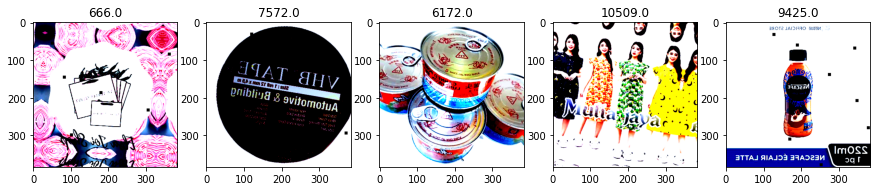

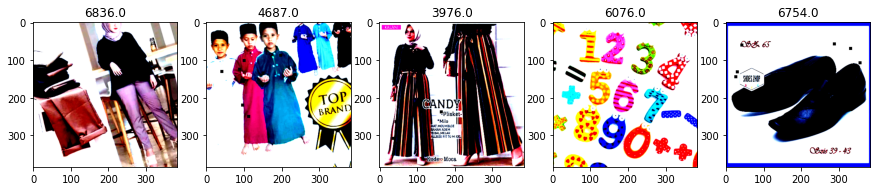

In [19]:
# 先看一下数据集返回的图片长什么样子
dataset = SHOPEEDataset(df_train, 'train', transform = transforms_train)
rcParams['figure.figsize'] = 15,5
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = i*5 + p
        img, label = dataset[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

## Model

In [21]:
# 载入ArcFace函数，下面代码不加注释，想搞明白的同学可以微信提问。
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [22]:
# 主模型网络
class SHOPEENet(nn.Module):
    def __init__(self, out_feature, backbone='densenet121', use_fc=True, pretrained=True):
        super(SHOPEENet, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained) # 创建骨干网络
        self.out_feature = out_feature # 模型输出的类别数(本次比赛数据是11014)
        self.pooling = nn.AdaptiveAvgPool2d(1) # 自定义一个pooling层

        # 替换骨干网络的最后一部分
        if "efficientnet" in CFG.model_arch:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.global_pool = nn.Identity()
            self.backbone.classifier = nn.Identity()
        elif "nfnet" in CFG.model_arch:
            self.in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()
        elif "swin" in CFG.model_arch:
            self.in_features = self.backbone.head.in_features
            # self.backbone.avgpool = nn.Identity()
            self.backbone.head = nn.Identity()

        print(self.in_features)
        
        # 定义全连接层（本方案不使用）
        self.use_fc = use_fc
        if self.use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(self.in_features, CFG.fc_dim)
            self.bn = nn.BatchNorm1d(CFG.fc_dim)
            self._init_params()
            self.in_features = CFG.fc_dim
            
        # 定义arcface层
        self.final = ArcMarginProduct(self.in_features, self.out_feature, s=CFG.s, m=CFG.margin, easy_margin=False, ls_eps=0.0)

    
    def _init_params(self): # 全连接层的初始化（本方案不使用）
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0) 
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x, labels=None):
        # 前向计算微调后的模型
        if "efficientnet" in CFG.model_arch or "nfnet" in CFG.model_arch:
            batch_size = x.shape[0]
            features = self.backbone(x)
            features = self.pooling(features).view(batch_size, -1)
            features = F.normalize(features)

        elif "swin" in CFG.model_arch:
            batch_size = x.shape[0]
            features = self.backbone(x)
            # features = self.pooling(features).view(batch_size, -1)
            features = F.normalize(features)

        # 使用全连接层（本方案不使用）
        if self.use_fc:
            features = self.dropout(features)
            features = self.fc(features)
            features = self.bn(features)

        # 如果有labels（训练阶段）则使用arface，如果没有label(验证或测试阶段)则直接返回图片的features
        if labels is not None:
            return self.final(features, labels)
        return features

In [23]:
# 创建模型
out_dim = df_train.label_group.nunique()
model = SHOPEENet(out_feature=out_dim, backbone=CFG.model_arch, use_fc=CFG.use_fc)


if CFG.gpu_parallel: # 根据配置决定是否启用多GPU
    num_gpu = torch.cuda.device_count()
    model = DataParallel(model, device_ids=range(num_gpu))
model.to(device);

1536


## Utils

In [24]:
# 训练函数
def train_func(train_loader):
    model.train() # 模型调整到训练模式
    bar = tqdm(train_loader) # 定义进度条，方便训练过程中查看
    losses = [] # 定义 loss列表
    for batch_idx, (images, targets) in enumerate(bar): # 从数据管道中导入 图片和标签
        images, targets = images.to(device), targets.to(device).long() # 将数据放入GPU

        optimizer.zero_grad() # 优化器置零
        logits = model(images, targets) # 把数据放入模型训练
        loss = criterion(logits, targets) # 计算loss
        loss.backward() # 反向传播
        optimizer.step() # 优化器迭代
            
        losses.append(loss.item()) # 存下当前的loss
        smooth_loss = np.mean(losses[-30:]) # 求近30步的平均loss
        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}, lr: {optimizer.param_groups[0]["lr"]:.7f}') # 更新进度条
    loss_train = np.mean(losses) # 求全体平均loss
    return loss_train # 返回全体平均loss


# 验证/测试中获取图片经模型处理后的features
def generate_test_features(test_loader):
    model.eval() # 模型调整到评估模式
    FEAS = [] 
    TARGETS = []
    with torch.no_grad():
        for batch_idx, (images) in enumerate(test_loader): # 从数据管道中导入 图片
            images = images.to(device) # 将数据放入GPU
            features = model(images) # 把数据放入模型获得features
            FEAS += [features.detach().cpu()] # 存下当前features
    FEAS = torch.cat(FEAS).cpu().numpy() 
    return FEAS # 返回所有数据的features

In [25]:
# 定义一个计算F1的函数
def row_wise_f1_score(labels, preds):
    scores = []
    for label, pred in zip(labels, preds):
        n = len(np.intersect1d(label, pred))
        score = 2 * n / (len(label)+len(pred))
        scores.append(score)
    return scores, np.mean(scores)

In [26]:
# 使用knn方法，寻找每张图片最近的其他图片，以匹配。
from sklearn.neighbors import NearestNeighbors ####
def get_image_predictions(df, embeddings):
    score_by_threshold = []
    best_score = 0
    best_threshold = -1
    df['target'] = df.label_group.map(df.groupby('label_group').posting_id.agg('unique').to_dict()) # 将标签转化成可计算的模式
    for thres in CFG.search_space: # 尝试循环所有阈值
        model = NearestNeighbors(n_neighbors = 50, metric = 'cosine') # 创建knn模型，使用cosine相似度评价。
        model.fit(embeddings) # 训练features
        distances, indices = model.kneighbors(embeddings) # 获得图片之间的距离（相似度）
        predictions = []
        for k in range(embeddings.shape[0]): # 每张图片都拿出来两两比对
            idx = np.where(distances[k,] < thres/100)[0] # 设置一个thres（阈值），来确定匹配的严格程度
            ids = indices[k,idx]
            posting_ids = df['posting_id'].iloc[ids].values # 输出匹配的图片
            predictions.append(posting_ids)
        
        scores, score = row_wise_f1_score(df.target, predictions) # 计算每张图片的F1得分
        df['score'] = scores
        selected_score = df.score.mean() # 计算平均得分
        score_by_threshold.append(selected_score)
        if selected_score > best_score:  # 如果当前得分超过了历史最好得分，则将当前得分存为历史最好得分
            best_score = selected_score
            best_threshold = thres
    
    #  做图，观察各个thres（阈值）的F1分数情况
    plt.title(f'Threshold Finder')
    plt.plot(score_by_threshold)
    plt.show()
    print(f'Best score is {best_score} and best threshold is {best_threshold/100}') # 打印最好的得分以及其对应的阈值


## Train

In [28]:
# 自定义一个scheduler(优化器的调度器)
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [29]:
criterion = nn.CrossEntropyLoss() # 创建损失函数
# 创建优化器
optimizer = Adam(model.parameters(), lr=CFG.init_lr/CFG.warmup_factor)  if CFG.scheduler_warmup in ["GradualWarmupSchedulerV3"] else Adam(model.parameters(), lr=CFG.init_lr)
scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr) # 创建调度器

# 创建升温调度器
if CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
    scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=CFG.warmup_factor, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

In [30]:
df_train_this = df_train[df_train['fold'] != CFG.fold_id] # 将不是fold_id部分的数据作为训练数据
df_valid_this = df_train[df_train['fold'] == CFG.fold_id] # 将fold_id部分的数据作为验证数据

# 计算每行的标签在验证集中出现的次数
df_valid_this['count'] = df_valid_this.label_group.map(df_valid_this.label_group.value_counts().to_dict())

dataset_train = SHOPEEDataset(df_train_this, 'train', transform = transforms_train) # 创建训练数据集
dataset_valid = SHOPEEDataset(df_valid_this, 'test', transform = transforms_valid) # 创建验证数据集

# 创建训练/验证数据集对应的数据管道
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.train_bs, shuffle=True, num_workers = CFG.n_worker, drop_last=True)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.valid_bs, shuffle=False, num_workers = CFG.n_worker, drop_last=False)

***** Epoch 0 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

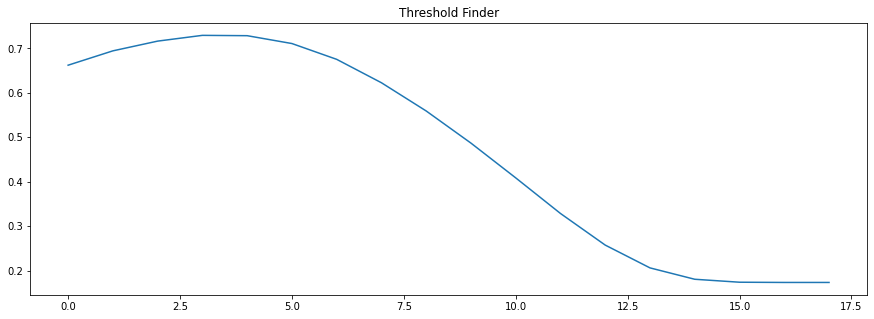

Best score is 0.7294369840779065 and best threshold is 0.25
valid elapsed time:  01:29
***** Epoch 1 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

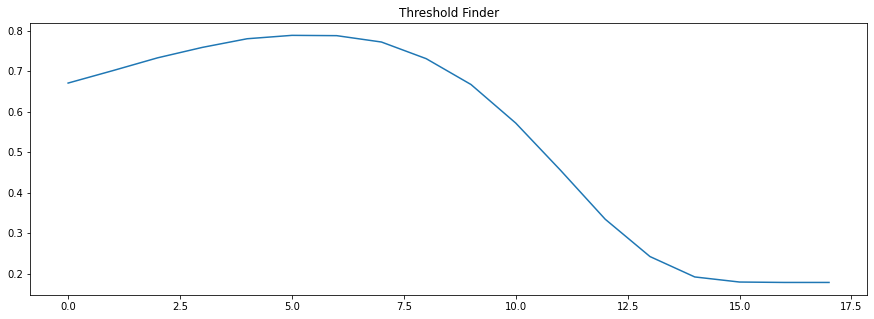

Best score is 0.7883763986101592 and best threshold is 0.35
valid elapsed time:  01:28
***** Epoch 2 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

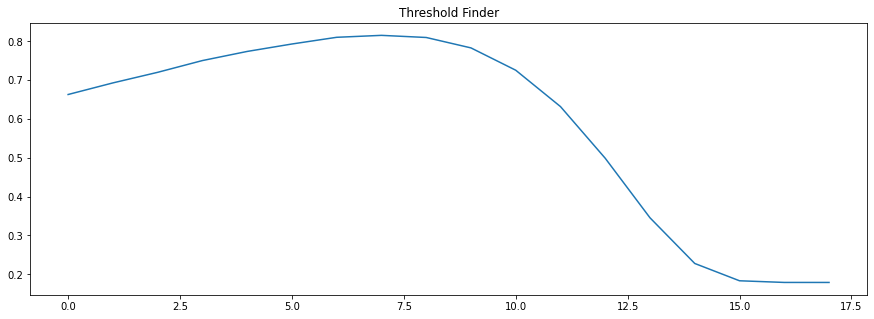

Best score is 0.8154426268949694 and best threshold is 0.45
valid elapsed time:  01:28
***** Epoch 3 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

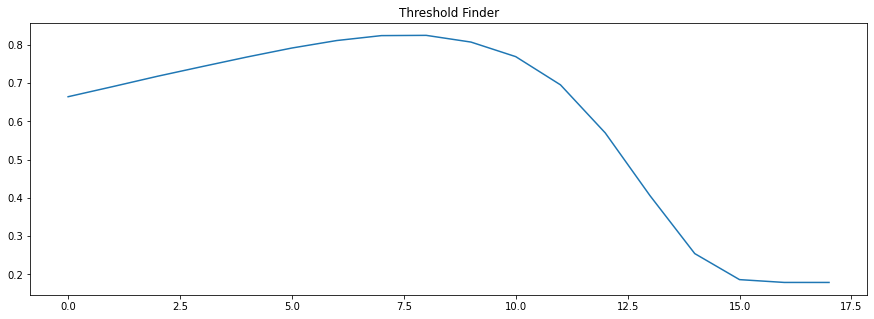

Best score is 0.8246974321947795 and best threshold is 0.5
valid elapsed time:  01:28
***** Epoch 4 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

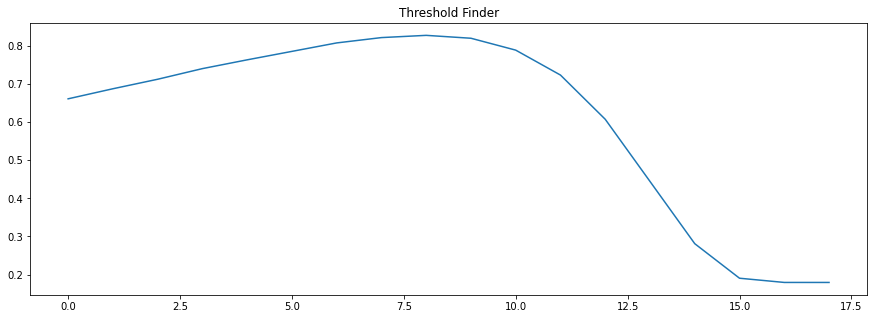

Best score is 0.8275692720841309 and best threshold is 0.5
valid elapsed time:  01:28
***** Epoch 5 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

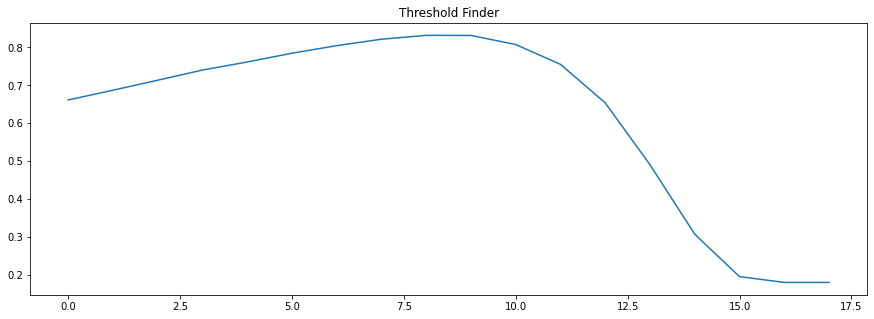

Best score is 0.8319345186918928 and best threshold is 0.5
valid elapsed time:  01:28
***** Epoch 6 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

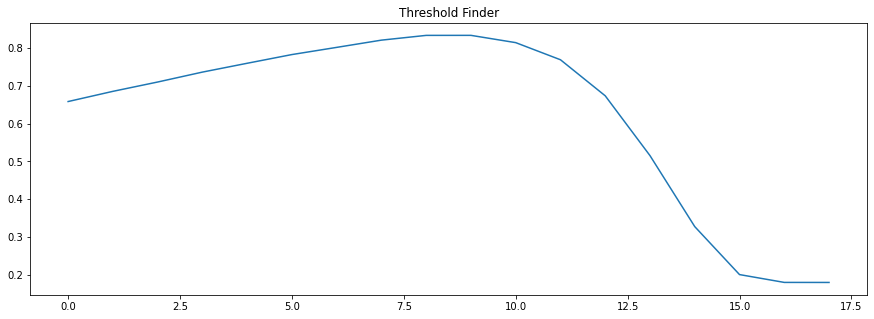

Best score is 0.8335305608354442 and best threshold is 0.55
valid elapsed time:  01:27
***** Epoch 7 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

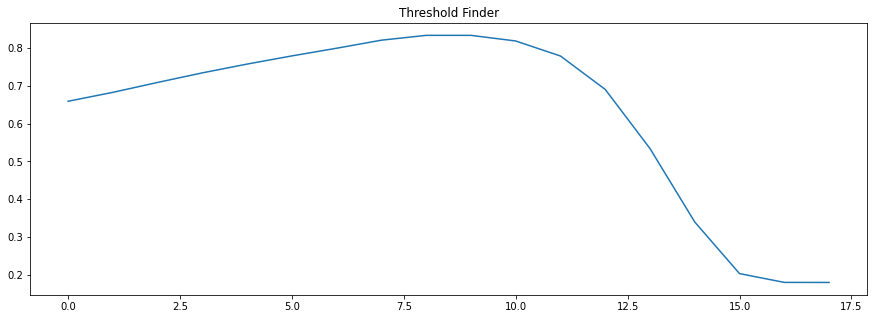

Best score is 0.8336135969975939 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 8 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

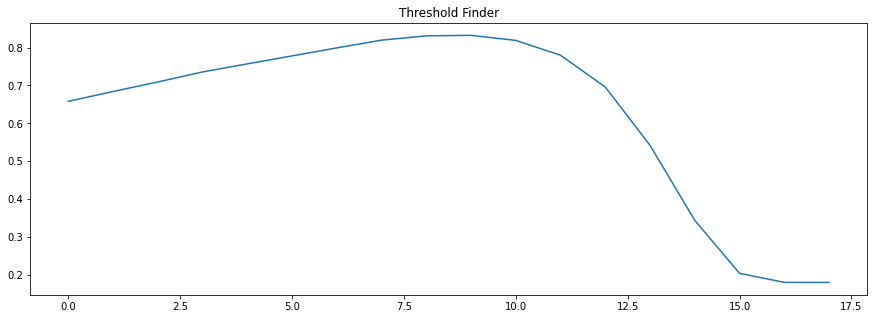

Best score is 0.8325425691512043 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 9 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

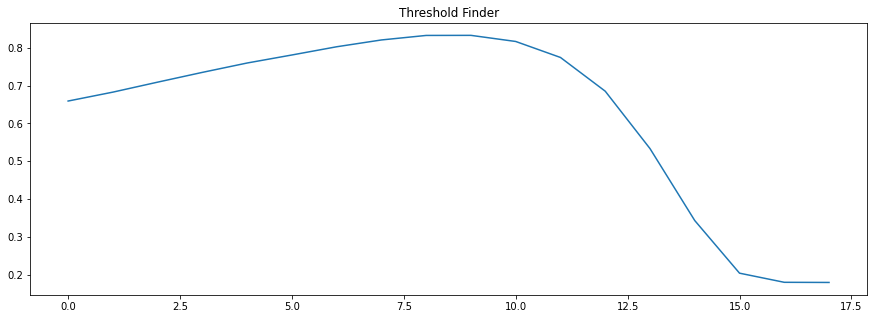

Best score is 0.8328858191944145 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 10 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

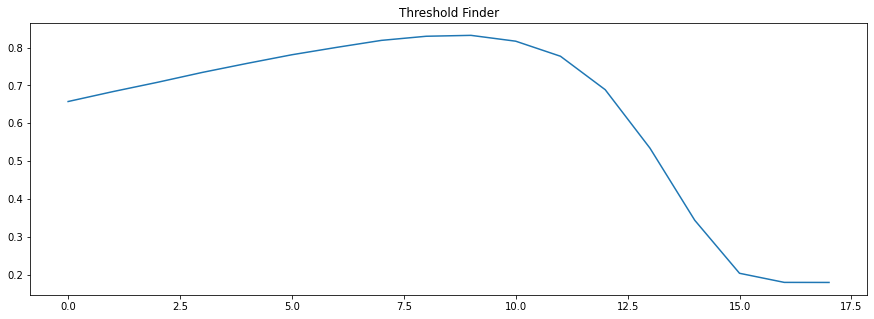

Best score is 0.8326254336596158 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 11 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

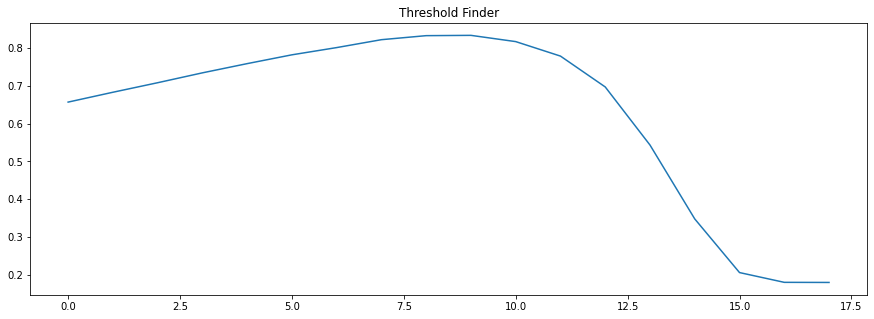

Best score is 0.8339424926646931 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 12 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

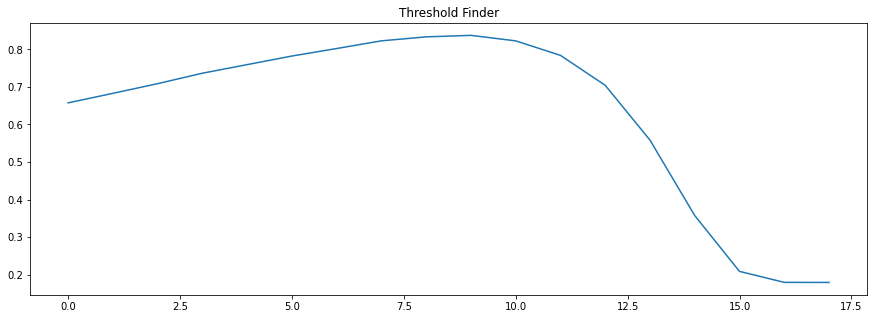

Best score is 0.8372602996064645 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 13 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

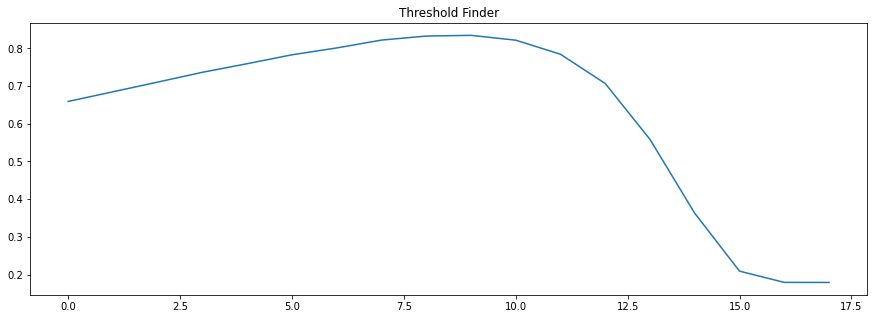

Best score is 0.8344284762929851 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 14 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

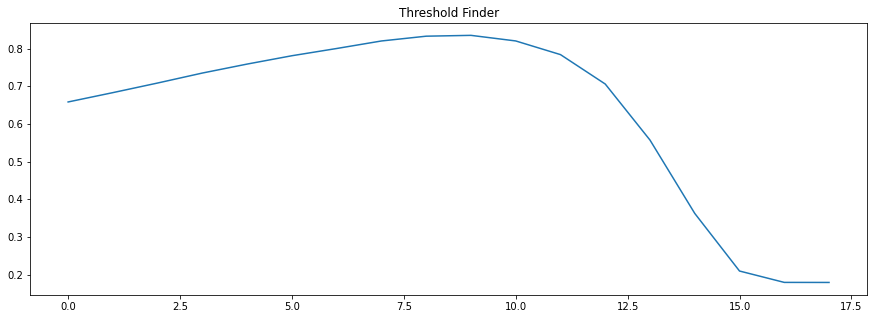

Best score is 0.8352853771674408 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 15 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

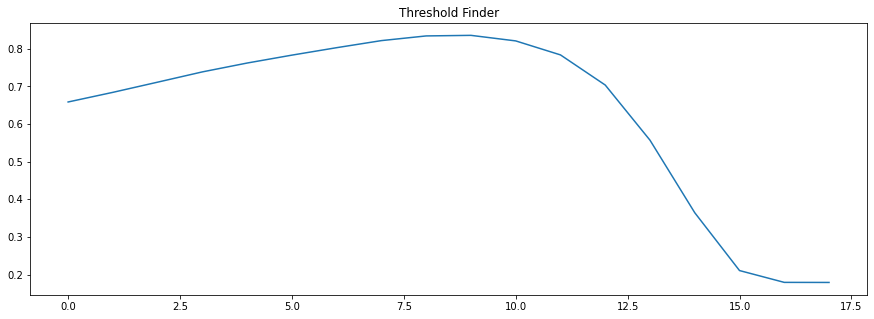

Best score is 0.8353725476102826 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 16 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

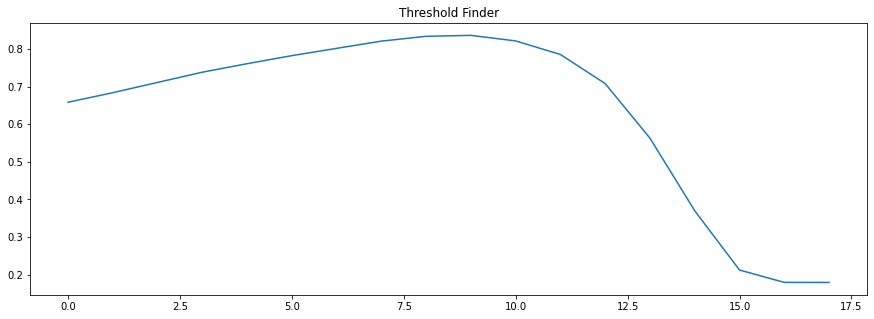

Best score is 0.8360859291423908 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 17 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

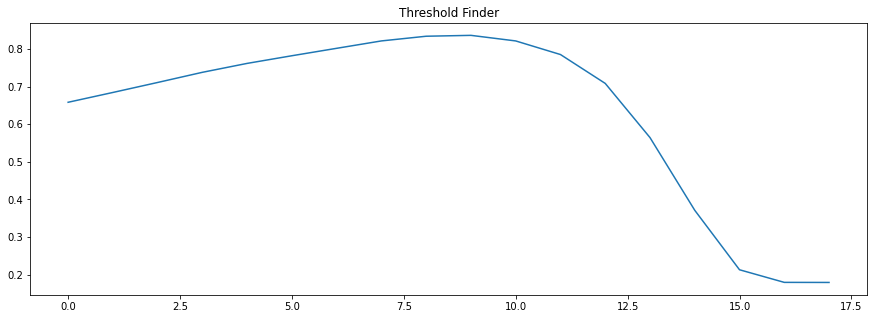

Best score is 0.8364145654559694 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 18 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

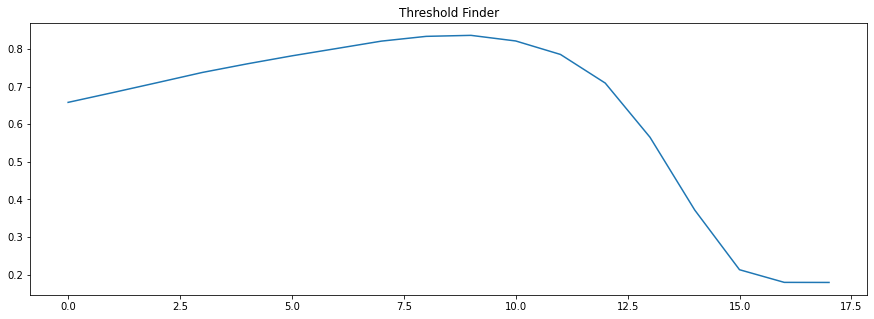

Best score is 0.836634564604281 and best threshold is 0.55
valid elapsed time:  01:28
***** Epoch 19 *****


  0%|          | 0/1141 [00:00<?, ?it/s]

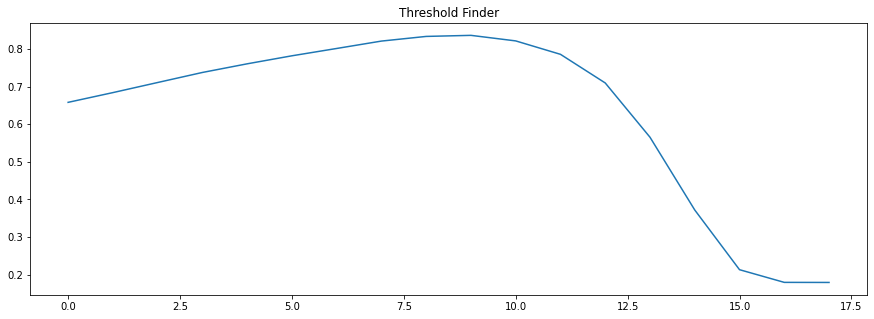

Best score is 0.8365540820401332 and best threshold is 0.55
valid elapsed time:  01:28


In [31]:
for epoch in range(CFG.n_epochs): # epoch循环
    print(f"***** Epoch {epoch} *****")
    loss_train = train_func(train_loader) # 训练
    # 调度器迭代
    if CFG.scheduler_warmup in ["GradualWarmupSchedulerV3"]:
        scheduler_warmup.step()
    elif CFG.scheduler in ["CosineAnnealingLR", "CosineAnnealingWarmRestarts"]:
        scheduler.step()
    
    # 验证
    if epoch % CFG.valid_every == 0 or epoch == CFG.n_epochs-1:
        start_time = time.time() # 验证开始时间戳
        FEAS = generate_test_features(valid_loader) # 获得验证集features
        get_image_predictions(df_valid_this, FEAS) # 使用features做匹配
        print("valid elapsed time: ", get_timediff(start_time,time.time())) # 打印验证花费时间
    # 保存模型
    if epoch >= CFG.save_after:
        torch.save(model.state_dict(), f'{outputdir}fold{CFG.fold_id}_{CFG.suffix}_{CFG.model_arch}_{CFG.image_size}_epoch{epoch}.pth')